In [1]:
ngram_range = [1,2]
n_terms = 4000
n_topics = 40
# n_topics = 20
max_iter = 20
n_top_terms = 9

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
TOKENS = pd.read_csv('TOKENS.csv')
TOKENS

,company_id,link_num,sent_num,token_num,pos_tuple,pos,token_str,term_str
0,1,0,0,0,"('Manufacturer', 'NNP')",NNP,Manufacturer,manufacturer
1,1,0,0,3,"('Hardware', 'NNP')",NNP,Hardware,hardware
2,1,0,0,4,"('Custom', 'NNP')",NNP,Custom,custom
3,1,0,0,5,"('Metal', 'NNP')",NNP,Metal,metal
4,1,0,0,6,"('Crafters', 'NNP')",NNP,Crafters,crafters
...,...,...,...,...,...,...,...,...
144146,1222,2,4,0,"('Success', 'NN')",NN,Success,success
144147,1222,2,5,1,"('message', 'NN')",NN,message,message
144148,1222,2,6,3,"('PentaCast', 'NNP')",NNP,PentaCast,pentacast
144149,1222,2,6,4,"('Inc', 'NNP')",NNP,Inc,inc


In [5]:
BAG = ['company_id', 'link_num']

In [6]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})
DOCS.sample(5)

,,doc_str
company_id,link_num,
693,0,divisions machine shops products matter projec...
890,0,hubs couplings keys propshaft scratch job bent...
349,21,sizes gates metal section embeds side walls fa...
103,0,qualifications supplier components assemblies ...
355,5,buyers design engineers time source castings c...


In [7]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names()

In [8]:
VOCAB = pd.DataFrame(index=TERMS)
VOCAB.index.name = 'term_str'

In [9]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [10]:
VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [11]:
DOCS.term_count.describe()

count    2110.000000
mean       39.860664
std        51.538378
min         0.000000
25%         6.000000
50%        24.000000
75%        52.000000
max       428.000000
Name: term_count, dtype: float64

In [12]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [13]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [14]:
lda_model = lda_engine.fit_transform(count_model)

In [15]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [16]:
colors = "YlGnBu"
THETA.sample(20).style.background_gradient(cmap=colors, axis=None)

,,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
company_id,link_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
475,41,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.181085,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.660582,0.004167,0.004167,0.004167
860,0,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.554164,0.001923,0.001923,0.001923,0.001923,0.119399,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.166900,0.001923,0.001923,0.001923,0.001923,0.001923,0.090306,0.001923,0.001923
487,2,0.001389,0.001389,0.001389,0.063415,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.578149,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.307047,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389,0.001389
225,17,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.955682,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136,0.001136
1086,3,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.308862,0.000234,0.000234,0.135344,0.000234,0.000234,0.336470,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.000234,0.210912,0.000234,0.000234,0.000234,0.000234,0.000234
340,15,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.013764,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.983038,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084,0.000084
472,2,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.108712,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.872661,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490,0.000490
611,0,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.972143,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714,0.000714
599,4,0.005000,0.005000,0.005000,0.227156,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.005000,0.382844,0.005000,0.005000,0.005000,0.205000,0.005000,0.005000,0.005000


In [17]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

In [18]:
PHI.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39
term_str,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
program,0.025000,0.025000,0.025000,0.025000,0.025000,1.034401,0.025000,14.224927,0.025000,0.025000,0.025000,0.025000,0.025000,3.866674,0.025000,3.021859,8.209563,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.251889,0.025000,2.438835,2.801370,0.751647,0.025000,0.025000,5.280676,0.025000,4.504126,0.025000,0.025000,2.914032
investor relations,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,5.025000,0.025000,0.025000,0.025000
offers announcements,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,20.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
billets,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,1.303690,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,1.746310,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
customer requirements,2.395621,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.871164,1.105684,0.025000,0.025000,0.025000,0.025000,15.451769,0.025000,0.025000,0.025000,0.025000,2.348771,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,5.769743,1.337082,0.025000,0.920166,0.025000,0.025000,0.025000,0.025000,0.025000
traffic,0.025000,0.025000,0.025000,0.025000,2.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000,9.854387,0.025000,0.025000,0.025000,0.025000,0.025000,5.195613,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,2.025000,1.025000,0.025000,0.025000,0.025000,0.025000,0.025000
edition bronze,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,7.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
sales ohiomagnetics,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,21.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000
delivery quality,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,3.627237,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,1.370761,1.077002,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000


In [19]:
TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(n_top_terms).reset_index().drop('topic_id', axis=1)['term_str'])

In [20]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8
topic_id,,,,,,,,,
T00,seat,lbs,alloys,phone,design,capabilities,phone email,covers,email
T01,anodes,member,information,member team,associations,team,staff,anode,phone
T02,order,page,website,browser,way,email,address,security,website page
T03,blocks,water,pool,block,unit,components,customer,wood,chain
T04,com,domain,information,hours,days,business,rights,domains,com com
T05,com,team,acracast com,acracast,quality,sales,customers,parts,industry
T06,com,precision,aluminium,au,products,policy,sales com,dans,experience
T07,manufacturing,solution,design,industry,service,customers,fittings,range,pricing
T08,bronze,brass,brass bronze,aluminum,alloys,aluminum brass,steel,link,pieces


In [21]:
TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:n_top_terms]), 1)

In [22]:
print(TOPICS.label.values)

['T00 seat, lbs, alloys, phone, design, capabilities, phone email, covers, email'
 'T01 anodes, member, information, member team, associations, team, staff, anode, phone'
 'T02 order, page, website, browser, way, email, address, security, website page'
 'T03 blocks, water, pool, block, unit, components, customer, wood, chain'
 'T04 com, domain, information, hours, days, business, rights, domains, com com'
 'T05 com, team, acracast com, acracast, quality, sales, customers, parts, industry'
 'T06 com, precision, aluminium, au, products, policy, sales com, dans, experience'
 'T07 manufacturing, solution, design, industry, service, customers, fittings, range, pricing'
 'T08 bronze, brass, brass bronze, aluminum, alloys, aluminum brass, steel, link, pieces'
 'T09 castings, sand, casting, mold, process, metal, aluminum, pattern, molds'
 'T10 powder, coating, facility, castings, request, powder coating, metals, services, customer'
 'T11 quality, parts, components, products, services, manufact

In [23]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

### Table of document and topic concentrations.

In [24]:
TOPICS

term_str,0,1,2,3,4,5,6,7,8,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,,,
T00,seat,lbs,alloys,phone,design,capabilities,phone email,covers,email,"T00 seat, lbs, alloys, phone, design, capabili...",43.383729,0.017218
T01,anodes,member,information,member team,associations,team,staff,anode,phone,"T01 anodes, member, information, member team, ...",39.352134,0.011508
T02,order,page,website,browser,way,email,address,security,website page,"T02 order, page, website, browser, way, email,...",53.550269,0.017603
T03,blocks,water,pool,block,unit,components,customer,wood,chain,"T03 blocks, water, pool, block, unit, componen...",38.327119,0.013292
T04,com,domain,information,hours,days,business,rights,domains,com com,"T04 com, domain, information, hours, days, bus...",42.629969,0.021209
T05,com,team,acracast com,acracast,quality,sales,customers,parts,industry,"T05 com, team, acracast com, acracast, quality...",43.683811,0.022352
T06,com,precision,aluminium,au,products,policy,sales com,dans,experience,"T06 com, precision, aluminium, au, products, p...",44.046109,0.017731
T07,manufacturing,solution,design,industry,service,customers,fittings,range,pricing,"T07 manufacturing, solution, design, industry,...",35.099217,0.022721
T08,bronze,brass,brass bronze,aluminum,alloys,aluminum brass,steel,link,pieces,"T08 bronze, brass, brass bronze, aluminum, all...",53.634119,0.018204


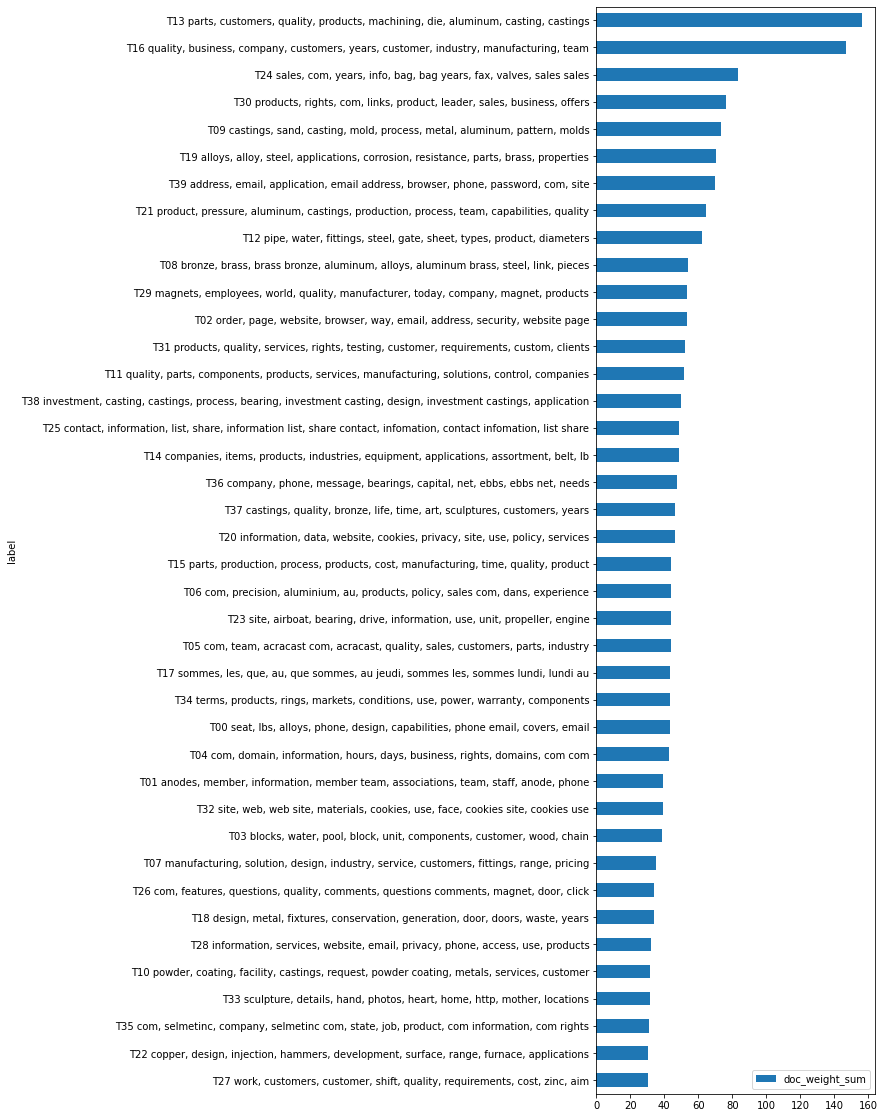

In [25]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, n_topics/2));

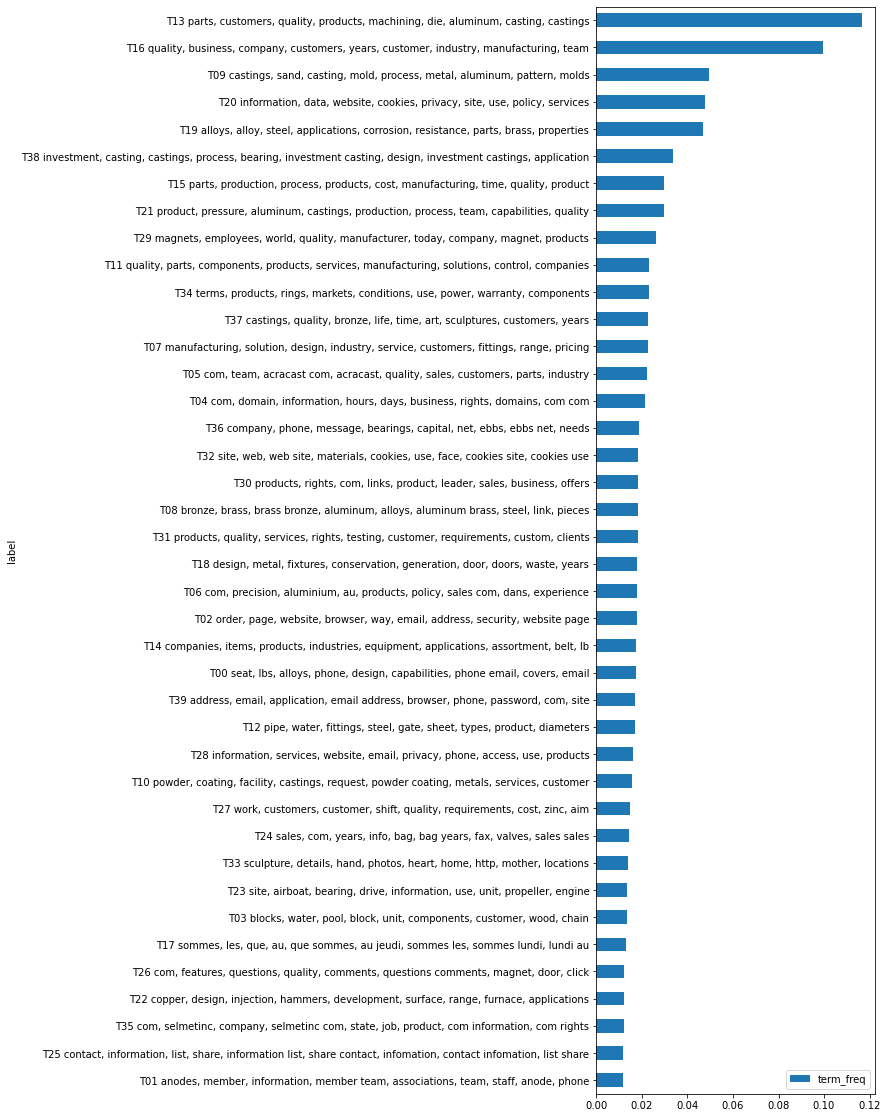

In [26]:
TOPICS.sort_values('term_freq', ascending=True).plot.barh(y='term_freq', x='label', figsize=(5,n_topics/2));

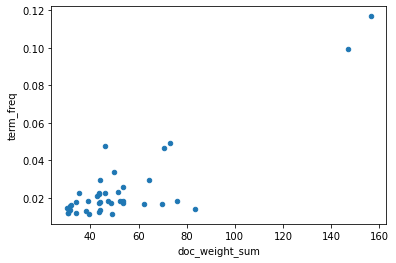

In [27]:
TOPICS.plot.scatter('doc_weight_sum', 'term_freq');

In [31]:
LIB = pd.read_csv('LIB.csv').rename(columns={'company_num':'company_id'})#.set_index('company_id')
LIB

,company_id,total_words,total_links
0,1,2796,26
1,5,368,9
2,10,845,11
3,12,1194,7
4,14,682,3
...,...,...,...
295,1211,968,7
296,1212,372,3
297,1216,1948,9
298,1219,2084,12
